# Customer Segmentation Report
    
    
The main target of this notebook is to explore the customers data, as well as the general german population data, find and interpret possible groups of individuals.

More precisely, are there any individuals from the general population whose characteristics are similar to those of the customers? If so, those individuals could be potential customers.

Task 1:
Compare between the general population `azdias`and the customer population from `customers`.

In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pickle
import time

from sklearn.preprocessing import MinMaxScaler 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance

import warnings
warnings.filterwarnings('ignore')

In [8]:
from src.helpers import *
from src.feature_selection import var_lists, get_feats
from src.read_data import *

from src.dimensionality_reduction import *

In [9]:
SEED = 0

In [10]:
clean_data_dict = load_dict('clean_data_dict')

data/clean_data_dict.pickle


In [11]:
azdias_clean    = clean_data_dict['azdias_data']
customers_clean = clean_data_dict['customers_data']
RF_vars         = clean_data_dict['RF_vars']
eli5_vars       = clean_data_dict['eli5_vars']

azdias_clean.shape, customers_clean.shape, len(RF_vars), len(eli5_vars)

((178244, 285), (63884, 285), 20, 6)

Create the pipeline

In [12]:
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop = 'first'))
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])
 

numerical_columns, categorical_columns = var_lists(azdias_clean)

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

pca_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('pca', PCA()),
    
])

In [13]:
%%time
pca_pipeline.fit(azdias_clean)

CPU times: user 40.7 s, sys: 2.79 s, total: 43.5 s
Wall time: 16.2 s


Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [14]:
pca_pipeline[1].explained_variance_ratio_[:80].sum()

0.7319148481806743

Variance explained with 28 variables: 0.5148785143138102
Variance explained with 56 variables: 0.6514523205908614
Variance explained with 84 variables: 0.7433449373867859
Variance explained with 112 variables: 0.8110589090790504
Variance explained with 140 variables: 0.863697635158234

The 25.0% of explained variance is achieved with 4 components
The 50.0% of explained variance is achieved with 25 components
The 75.0% of explained variance is achieved with 86 components
The 90.0% of explained variance is achieved with 165 components


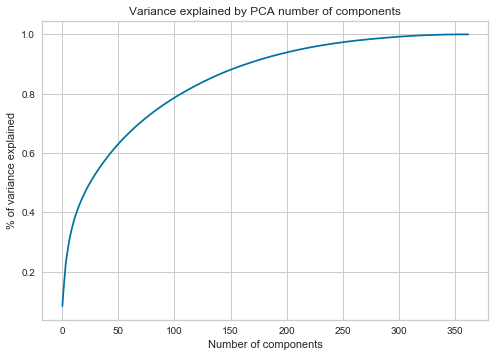


CPU times: user 206 ms, sys: 17.8 ms, total: 224 ms
Wall time: 219 ms


In [15]:
%%time

decide_pca_components(azdias_clean, pca_pipeline)

We will choose 60 variables, as we can explain around 67 % of the variance and we reduce drastically the number of components so that the clustering algorithm will be able to find more easily the groups of customers.

In [16]:
N_COMPONENTS = 60

In [17]:
pca_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('pca', PCA(N_COMPONENTS)),
    
])

Let's transform the azdias data using the PCA method.

In [18]:
azdias_pca = pca_pipeline.fit_transform(azdias_clean)

## Clustering

Start by ading k-means clustering to the previous pipeline and select an optimal number of clusters.

In [30]:
kmeans_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('pca', PCA(N_COMPONENTS)),
    ('kmeans', KMeans()),
    
])

kmeans_pipeline.fit(azdias_clean)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

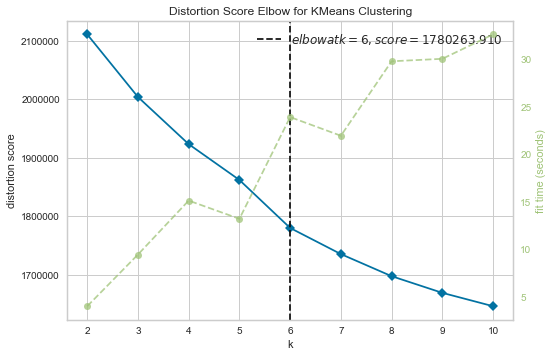

CPU times: user 4min 7s, sys: 15.6 s, total: 4min 22s
Wall time: 3min 1s


In [31]:
%%time

model = kmeans_pipeline['kmeans']
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(azdias_pca)
visualizer.show()

### Silhouette score

We will compute the average silhouette score for each point.

The closer to 1 that average is, the better clustered the points are.

We will take a sample of 50K rows to speed up the computations a little bit.

In [32]:
sampled = azdias_clean.sample(50000, random_state=SEED)
sampled_pca = pca_pipeline.fit_transform(sampled)
cluster_labels = kmeans_pipeline.fit_predict(sampled)

sampled.shape, sampled_pca.shape, cluster_labels.shape

((50000, 285), (50000, 60), (50000,))

In [33]:
%%time

print('Silhouette score: ', silhouette_score(sampled_pca, cluster_labels))

Silhouette score:  0.083336496988913
CPU times: user 41.9 s, sys: 29.3 s, total: 1min 11s
Wall time: 24.9 s


In [34]:
%%time

for i in range(2,12,2):
    kpipe = Pipeline([
    ('preprocess', preprocessing),
    ('pca', PCA(N_COMPONENTS)),
    ('kmeans', KMeans(i)),
    ])
    
    cluster_labels = kmeans_pipeline.fit_predict(sampled)
    print(f'Silhouette score for {i} clusters: {silhouette_score(sampled_pca, cluster_labels)} ')
    

Silhouette score for 2 clusters: 0.0835718566613641 
Silhouette score for 4 clusters: 0.08346525796653692 
Silhouette score for 6 clusters: 0.08330432911883902 
Silhouette score for 8 clusters: 0.08523486695150384 
Silhouette score for 10 clusters: 0.0835770049299996 
CPU times: user 5min 26s, sys: 2min 32s, total: 7min 59s
Wall time: 2min 53s


It seems 6 is the best possible value, using the elbow rule. Also, it has a silhouette score quite similar to the other `k` tested.

Let's try it.

In [35]:
N_CLUSTERS = 6

kmeans_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('pca', PCA(N_COMPONENTS)),
    ('kmeans', KMeans(N_CLUSTERS)),
    
])

kmeans_pipeline.fit(azdias_clean)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

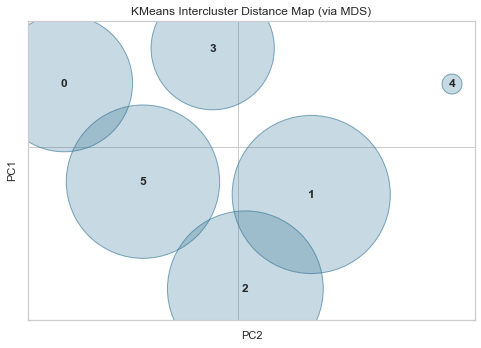

In [36]:
model = kmeans_pipeline['kmeans']
visualizer = InterclusterDistance(model, legend = False, random_state=SEED)

visualizer.fit(azdias_pca)
visualizer.show()

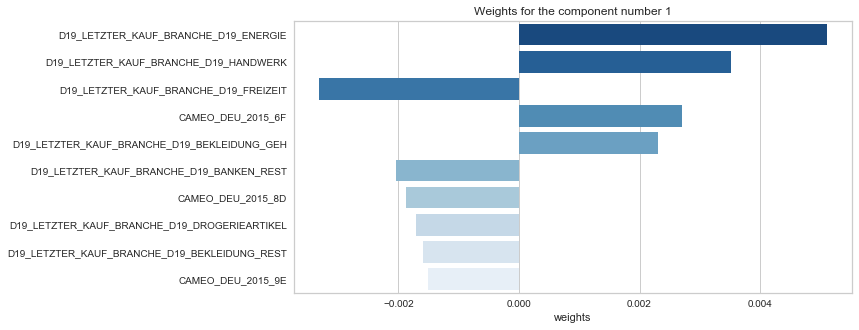

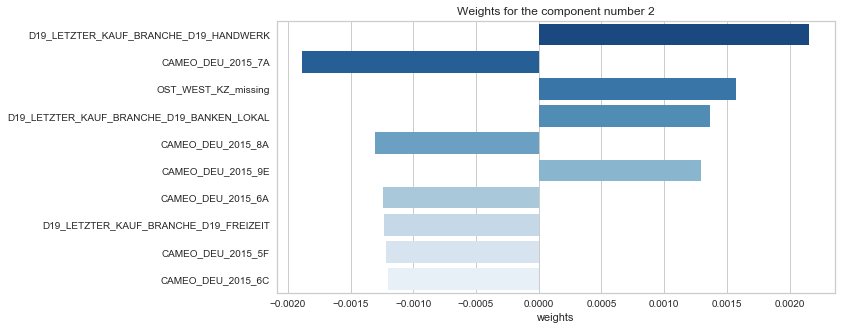

In [37]:
# see and interpret the first two pca components
feats = get_feats(pca_pipeline, categorical_columns, numerical_columns)
azdias_scaled = pd.DataFrame(pca_pipeline[0].fit_transform(azdias_clean), columns = feats)

plot_PCA_weights(pca_pipeline, azdias_scaled, component_num = 1, n = N_COMPONENTS) 
plot_PCA_weights(pca_pipeline, azdias_scaled, component_num = 2, n = N_COMPONENTS) 

## Interpret the results

In [38]:
labels = kmeans_pipeline.fit_predict(azdias_clean)

In [39]:
azdias_clean['labels'] = labels

In [40]:
azdias_clean.labels.value_counts()

2    42295
0    41568
3    38121
4    36834
1    16484
5     2942
Name: labels, dtype: int64

In [41]:
def create_cluster_summary(df, subset_vars = None):
    if subset_vars:
        df = df[set(subset_vars)|set(['labels'])]
        
    summary_clusters = df.groupby('labels').mean().reset_index(drop=True).T
    summary_clusters['mean'] = df.mean()
    return summary_clusters

In [42]:
summary_clusters = create_cluster_summary(azdias_clean, subset_vars = RF_vars)

In [43]:
summary_clusters['mean_customers'] = customers_clean[RF_vars].mean()
summary_clusters

,0,1,2,3,4,5,mean,mean_customers
AGER_TYP,0.336870,-0.956625,-0.374985,-0.264001,-0.948390,-0.489123,-0.359406,0.128296
CJT_GESAMTTYP,2.570312,4.925781,3.611328,3.865234,4.093750,3.175781,3.638047,0.260986
RT_KEIN_ANREIZ,2.416016,3.646484,3.275391,2.865234,4.328125,3.080078,3.236504,0.260986
LP_FAMILIE_FEIN,2.558594,1.690430,2.707031,7.132812,3.117188,1.991211,3.595524,0.521973
CJT_TYP_5,4.414062,4.242188,2.898438,3.464844,2.169922,3.496094,3.355854,0.260986
LP_STATUS_FEIN,6.132812,4.820312,1.873047,7.816406,3.638672,2.345703,4.781364,0.521973
HH_EINKOMMEN_SCORE,4.035156,2.027344,5.550781,3.097656,4.812500,5.417969,4.212259,0.260254
CJT_TYP_3,4.371094,4.222656,2.837891,3.417969,2.302734,3.494141,3.347493,0.260986
AKT_DAT_KL,3.730469,5.800781,5.195312,2.376953,6.210938,6.468750,4.424029,0.677734
FINANZ_MINIMALIST,3.946666,3.092150,2.249391,3.999239,2.103573,2.509177,3.071542,0.256592


In [44]:
summary_clusters.T.iloc[:-2,:]

,AGER_TYP,CJT_GESAMTTYP,RT_KEIN_ANREIZ,LP_FAMILIE_FEIN,CJT_TYP_5,LP_STATUS_FEIN,HH_EINKOMMEN_SCORE,CJT_TYP_3,AKT_DAT_KL,FINANZ_MINIMALIST,EINGEZOGENAM_HH_JAHR,D19_KONSUMTYP,RT_SCHNAEPPCHEN,ALTERSKATEGORIE_FEIN,SEMIO_LUST,D19_SOZIALES,ALTERSKATEGORIE_GROB,CJT_TYP_1,CJT_TYP_6,VK_DHT4A
0,0.336870,2.570312,2.416016,2.558594,4.414062,6.132812,4.035156,4.371094,3.730469,3.946666,2002.0,6.679688,4.093750,9.484375,5.367446,0.815430,3.573494,2.078125,4.449219,7.210938
1,-0.956625,4.925781,3.646484,1.690430,4.242188,4.820312,2.027344,4.222656,5.800781,3.092150,2004.0,6.304688,4.511719,12.898438,4.807389,0.275146,2.396930,4.265625,4.292969,7.691406
2,-0.374985,3.611328,3.275391,2.707031,2.898438,1.873047,5.550781,2.837891,5.195312,2.249391,2005.0,6.269531,3.513672,14.070312,4.259274,0.349365,2.738503,3.460938,3.095703,6.867188
3,-0.264001,3.865234,2.865234,7.132812,3.464844,7.816406,3.097656,3.417969,2.376953,3.999239,2002.0,3.050781,3.710938,14.531250,4.302510,1.087891,2.846122,3.267578,3.345703,3.085938
4,-0.948390,4.093750,4.328125,3.117188,2.169922,3.638672,4.812500,2.302734,6.210938,2.103573,2007.0,6.296875,3.851562,17.484375,3.116170,0.175415,1.979937,4.464844,2.500000,6.417969
5,-0.489123,3.175781,3.080078,1.991211,3.496094,2.345703,5.417969,3.494141,6.468750,2.509177,2005.0,6.984375,4.402344,12.046875,5.237593,0.406006,3.056764,2.914062,3.794922,8.070312


In [45]:
def plot_cluster_info(summary_clusters, k = N_CLUSTERS, n_cols = 5):
    var_list = summary_clusters.index.tolist()

    number_subplots = len(var_list)
    base_color = sns.color_palette()[0]
    plt.figure(figsize=(35, 40))

    for i, col in enumerate(var_list):
        ax = plt.subplot(int(number_subplots/n_cols)+1,n_cols,i+1)

        sns.barplot(y=col, x=[f'{i}' for i in range(0, N_CLUSTERS)], 
                    data=summary_clusters.T.iloc[:-2,:], color=base_color);
        plt.title(f"{col}", fontsize=20)
        ax.axhline(y=summary_clusters.T.loc['mean', col], linewidth=2, color='r')
        # just for this problem: avg of the customers group for the selected variables
        ax.axhline(y=customers_clean[RF_vars].mean()[col], linewidth=3, color='g')
        plt.ylabel("")

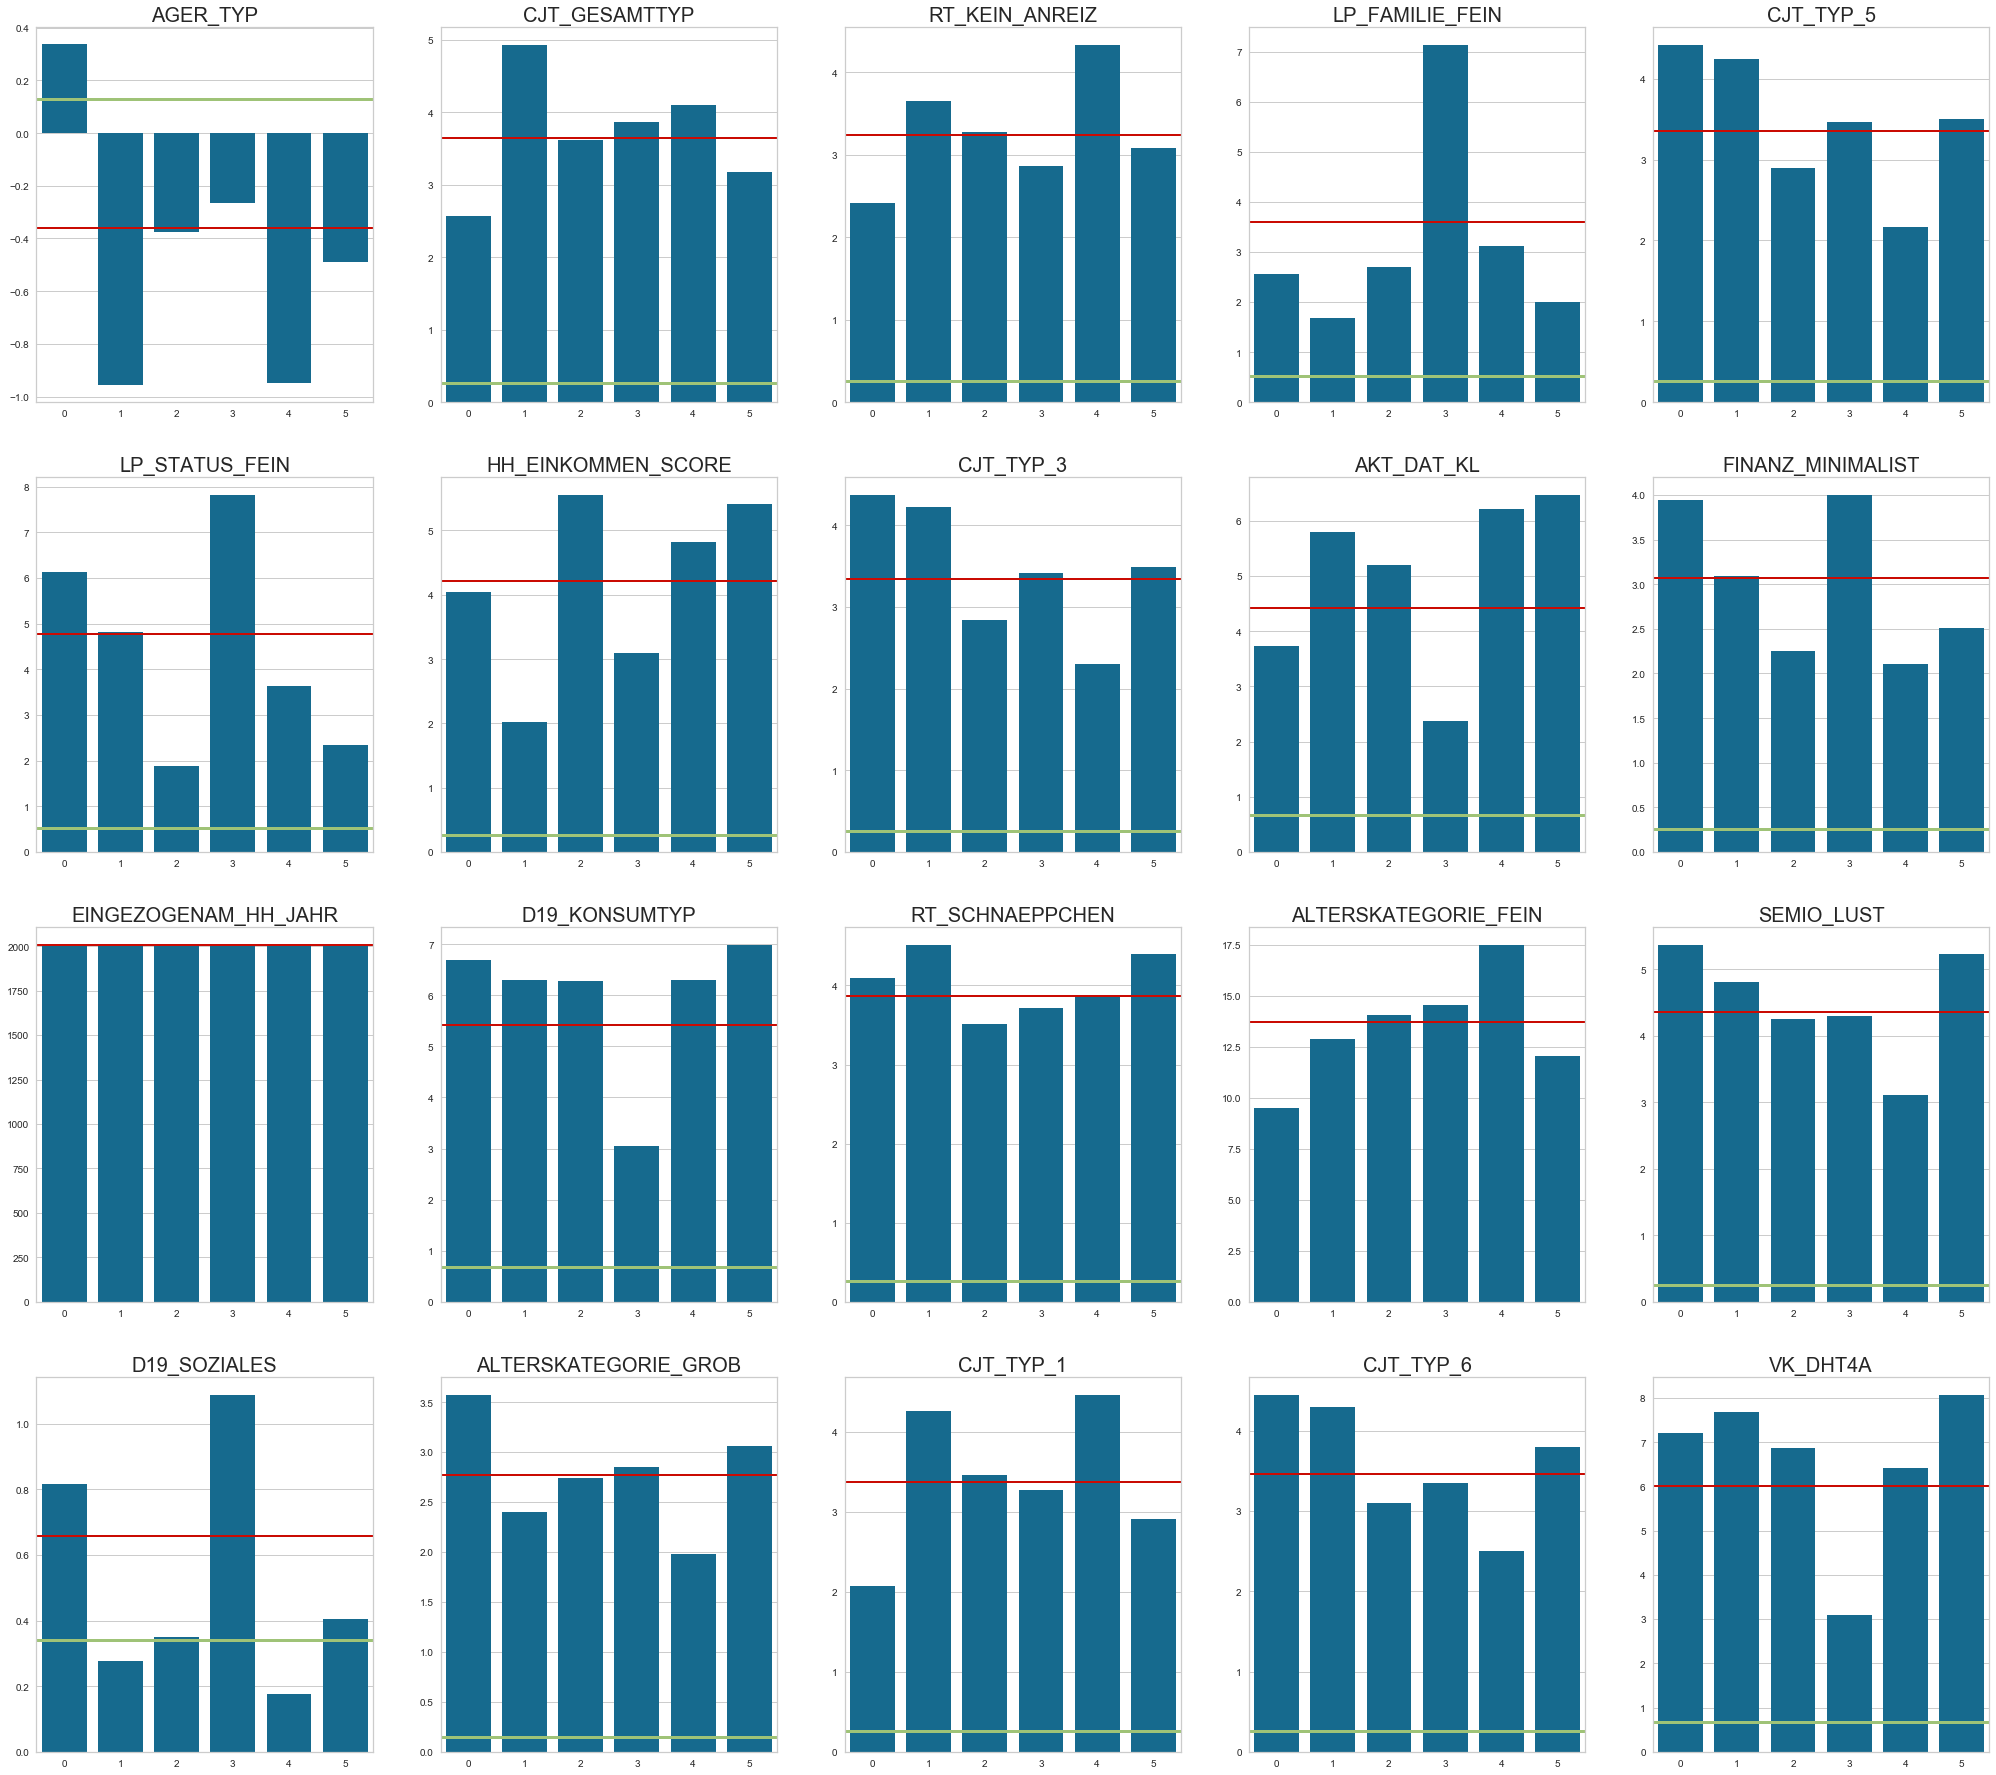

In [46]:
plot_cluster_info(summary_clusters)

# Add labels to train and test data

In [51]:
# test: does it work to use the model with another df?
customer_labels = kmeans_pipeline.predict(customers_clean)
customers_clean['labels'] = customer_labels

In [52]:
customers_clean.shape, azdias_clean.shape

((63884, 286), (178244, 286))

In [59]:
prop_df

,cluster,population_prop,customers_prop
0,0,0.233208,0.309076
1,1,0.092480,0.246102
2,2,0.237287,0.081069
3,3,0.213870,0.344766
4,4,0.206649,0.013822
5,5,0.016505,0.005166


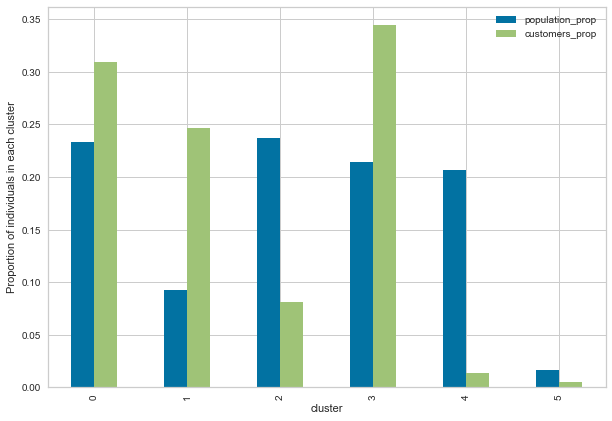

In [64]:
general_prop = []
customers_prop = []
x = [i for i in range(N_CLUSTERS)]

for i in range(N_CLUSTERS):
    general_prop.append((labels == i).sum()/len(labels))
    customers_prop.append((customer_labels == i).sum()/len(customer_labels))


prop_df = pd.DataFrame({'cluster' : x, 'population_prop' : general_prop, 'customers_prop':customers_prop})
prop_df.plot(x='cluster', y = ['population_prop', 'customers_prop'], kind='bar', figsize=(10,7))
plt.ylabel('Proportion of individuals in each cluster')
plt.show()


This suggest that the individuals from clusters 0, 1 and 3 are good candidates to be new customers. This is because there is a high proportion of customers but not so many people overall.

In [65]:
# save the pca and kmeans pipelines
save_pipeline(pca_pipeline, 'pca_pipeline')
save_pipeline(kmeans_pipeline, 'kmeans_pipeline')

Pipeline saved to pca_pipeline
Pipeline saved to kmeans_pipeline
